In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
# define function that creates a KS plot to test for overtraining of our classifiers
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - True labels of training set.
        train_proba - np.ndarray of classifier output probabilities for the training set.
                      Same shape as y_train. 0-1 probabilities from model.
        y_test - True labels of testing set.
        test_proba - np.ndarray of classifier output probabilities for the testing set.
                     Same shape as y_test. 0-1 probabilities from model.
        bins - Number of bins for viz. Default 30.
        fig_sz - Figure size of the output matplotlib figure. Default (10,8).
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [4]:
# load training and testing arrays along with their labels and variable and label names
# such a file is created at the end of the explore.ipynb notebook
with np.load('root_files/train_test_49variables.npz') as f:
    X_train_final = f['X_train']
    y_train = f['y_train']
    X_test_final = f['X_test']
    y_test = f['y_test']
    features = f['variables'].tolist()
    labels = f['labels'].tolist()

In [5]:
# build a simple neural network in keras and save the initial random weights into a file

keras_model = keras.Sequential()
keras_model.add(BatchNormalization(input_shape=(X_train_final.shape[1],)))
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 60)                3000      
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 6,978
Trainable params: 6,880
Non-trainable params: 98
_________________________________________________________________
None


In [6]:
# train the model for 10 epochs for different values of learning rate and keep the value of the loss function
# for each learning rate at the end of the 10th epoch
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final, y_train, batch_size=2**16, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10


2022-11-08 22:11:32.259786: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


55/55 [==============================] - 1s 16ms/step - loss: 0.7565 - accuracy: 0.4606
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7101 - accuracy: 0.5316
Epoch 3/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6745 - accuracy: 0.5949
Epoch 4/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6457 - accuracy: 0.6395
Epoch 5/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6216 - accuracy: 0.6708
Epoch 6/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6008 - accuracy: 0.6943
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5826 - accuracy: 0.7127
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5665 - accuracy: 0.7275
Epoch 9/10
55/55 [==============================] - 1s 15ms/step - loss: 0.5520 - accuracy: 0.7396
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5390 - accuracy: 0.7495
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 15ms/step - loss: 0.6250 - accuracy: 0.6663
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5897 - accuracy: 0.7056
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5613 - accuracy: 0.7318
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5378 - accuracy: 0.7503
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5180 - accuracy: 0.7641
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5009 - accuracy: 0.7748
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4862 - accuracy: 0.7831
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4732 - accuracy: 0.7899
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7366 - accuracy: 0.4909
Epoch 2/10
55/55 [==============================] - 1s 15ms/step - loss: 0.6659 - accuracy: 0.6083
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.4956 - accuracy: 0.7778
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4721 - accuracy: 0.7904
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4530 - accuracy: 0.7997
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4371 - accuracy: 0.8069
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4237 - accuracy: 0.8127
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4121 - accuracy: 0.8178
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.7099 - accuracy: 0.5354
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.6144 - accuracy: 0.6780
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.5573 - accuracy: 0.7348
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.5173 - accuracy: 0.7644
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.3944 - accuracy: 0.8259
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3808 - accuracy: 0.8327
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3695 - accuracy: 0.8387
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3599 - accuracy: 0.8440
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.6736 - accuracy: 0.5913
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.5534 - accuracy: 0.7371
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4917 - accuracy: 0.7798
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4525 - accuracy: 0.7998
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4249 - accuracy: 0.8122
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4041 - accuracy: 0.8214
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.3263 - accuracy: 0.8625
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3192 - accuracy: 0.8661
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.6273 - accuracy: 0.6492
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.4881 - accuracy: 0.7813
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4288 - accuracy: 0.8104
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3941 - accuracy: 0.8261
Epoch 5/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3705 - accuracy: 0.8381
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3534 - accuracy: 0.8476
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3403 - accuracy: 0.8549
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3301 - accuracy: 0.8605
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.5731 - accuracy: 0.7022
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4258 - accuracy: 0.8117
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3739 - accuracy: 0.8364
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3454 - accuracy: 0.8521
Epoch 5/10
55/55 [==============================] - 1s 18ms/step - loss: 0.3271 - accuracy: 0.8620
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3144 - accuracy: 0.8685
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3048 - accuracy: 0.8731
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2972 - accuracy: 0.8766
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2908 - accuracy: 0.8796
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2854 - accuracy: 0.8820
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.3298 - accuracy: 0.8605
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3085 - accuracy: 0.8713
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2949 - accuracy: 0.8776
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2850 - accuracy: 0.8822
Epoch 7/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2773 - accuracy: 0.8858
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2709 - accuracy: 0.8887
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2656 - accuracy: 0.8911
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2609 - accuracy: 0.8932
Epoch 1/10
55/55 [==============================] - 1s 21ms/step - loss: 0.5079 - accuracy: 0.7508
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3656 - accuracy: 0.8410
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.2691 - accuracy: 0.8895
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2606 - accuracy: 0.8933
Epoch 7/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2537 - accuracy: 0.8964
Epoch 8/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2479 - accuracy: 0.8989
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2429 - accuracy: 0.9010
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2384 - accuracy: 0.9028
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.4516 - accuracy: 0.7862
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3237 - accuracy: 0.8635
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2935 - accuracy: 0.8783
Epoch 4/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2772 - accuracy: 0.8858
Epoch 5/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2315 - accuracy: 0.9056
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2258 - accuracy: 0.9079
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2210 - accuracy: 0.9098
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2169 - accuracy: 0.9114
Epoch 1/10
55/55 [==============================] - 1s 20ms/step - loss: 0.4010 - accuracy: 0.8164
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2923 - accuracy: 0.8788
Epoch 3/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2679 - accuracy: 0.8900
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2537 - accuracy: 0.8964
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2435 - accuracy: 0.9008
Epoch 6/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2354 - accuracy: 0.9041
Epoch 7/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2030 - accuracy: 0.9175
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2001 - accuracy: 0.9187
Epoch 1/10
55/55 [==============================] - 1s 17ms/step - loss: 0.3584 - accuracy: 0.8402
Epoch 2/10
55/55 [==============================] - 1s 18ms/step - loss: 0.2670 - accuracy: 0.8905
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2452 - accuracy: 0.9001
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2315 - accuracy: 0.9056
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2217 - accuracy: 0.9096
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2144 - accuracy: 0.9125
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2089 - accuracy: 0.9149
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2046 - accuracy: 0.9167
Epoch 9/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.3242 - accuracy: 0.8574
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2446 - accuracy: 0.9003
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2236 - accuracy: 0.9088
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2115 - accuracy: 0.9138
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2039 - accuracy: 0.9170
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1991 - accuracy: 0.9191
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1959 - accuracy: 0.9205
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1932 - accuracy: 0.9217
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1908 - accuracy: 0.9227
Epoch 10/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1887 - accuracy: 0.9236
Epoch 1/10
55/55 [==

55/55 [==============================] - 1s 16ms/step - loss: 0.2155 - accuracy: 0.9117
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2055 - accuracy: 0.9162
Epoch 5/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1999 - accuracy: 0.9185
Epoch 6/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1944 - accuracy: 0.9209
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1911 - accuracy: 0.9224
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1882 - accuracy: 0.9237
Epoch 9/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1839 - accuracy: 0.9256
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1854 - accuracy: 0.9250
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3053 - accuracy: 0.8653
Epoch 2/10
55/55 [==============================] - 1s 17ms/step - loss: 0.2318 - accuracy: 0.9052
Epoch 3/10
55/55 [==

55/55 [==============================] - 1s 17ms/step - loss: 0.1950 - accuracy: 0.9205
Epoch 6/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1909 - accuracy: 0.9224
Epoch 7/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1861 - accuracy: 0.9246
Epoch 8/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1866 - accuracy: 0.9243
Epoch 9/10
55/55 [==============================] - 1s 16ms/step - loss: 0.1815 - accuracy: 0.9267
Epoch 10/10
55/55 [==============================] - 1s 17ms/step - loss: 0.1818 - accuracy: 0.9265
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.3092 - accuracy: 0.8650
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2273 - accuracy: 0.9062
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2066 - accuracy: 0.9154
Epoch 4/10
55/55 [==============================] - 1s 16ms/step - loss: 0.2037 - accuracy: 0.9165
Epoch 5/10
55/55 [==

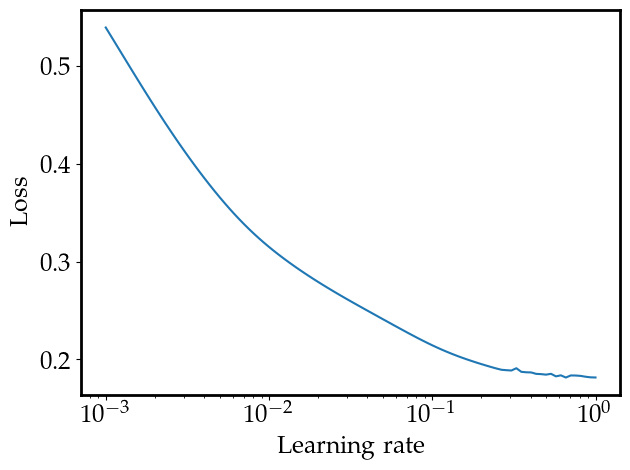

In [7]:
# plot the loss vs the learning rate to find the optimal learning rate (lowest loss at epoch 10)
plt.figure()
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.tight_layout()
plt.savefig('plots/lr.pdf')
plt.show()

In [8]:
# keep the optimal learning rate and print it
lr = rates[np.nanargmin(losses)]
print(lr)

0.6579332246575682


In [9]:
%%time
# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint]

# fit keras model with using the calculated optimal learning rate and save the best weights in a file
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final, y_train, batch_size=2**16, 
                          epochs=100, shuffle=False, callbacks = callbacks, 
                          validation_data=(X_test_final,y_test))

Epoch 1/100
55/55 [==============================] - 2s 38ms/step - loss: 0.3046 - accuracy: 0.8658 - val_loss: 0.2353 - val_accuracy: 0.9041
Epoch 2/100
55/55 [==============================] - 1s 18ms/step - loss: 0.2277 - accuracy: 0.9066 - val_loss: 0.2091 - val_accuracy: 0.9151
Epoch 3/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2134 - accuracy: 0.9127 - val_loss: 0.2326 - val_accuracy: 0.9047
Epoch 4/100
55/55 [==============================] - 1s 17ms/step - loss: 0.2048 - accuracy: 0.9163 - val_loss: 0.1967 - val_accuracy: 0.9205
Epoch 5/100
55/55 [==============================] - 1s 17ms/step - loss: 0.1971 - accuracy: 0.9197 - val_loss: 0.1883 - val_accuracy: 0.9239
Epoch 6/100
55/55 [==============================] - 1s 17ms/step - loss: 0.1923 - accuracy: 0.9218 - val_loss: 0.1892 - val_accuracy: 0.9238
Epoch 7/100
55/55 [==============================] - 1s 17ms/step - loss: 0.1905 - accuracy: 0.9225 - val_loss: 0.1837 - val_accuracy: 0.9261
Epoch 

In [10]:
# reload best weights
keras_model.load_weights('keras_model_best.h5')

In [11]:
# run model inference on train and test data sets
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 263us/step


In [12]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])

In [13]:
# print the loss and accuracy of the model on the train and test data sets
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 41s 370us/step - loss: 0.1613 - accuracy: 0.9357
[0.16129709780216217, 0.935696542263031]
13921/13921 [==============================] - 5s 371us/step - loss: 0.1626 - accuracy: 0.9356
[0.16255471110343933, 0.9355683326721191]


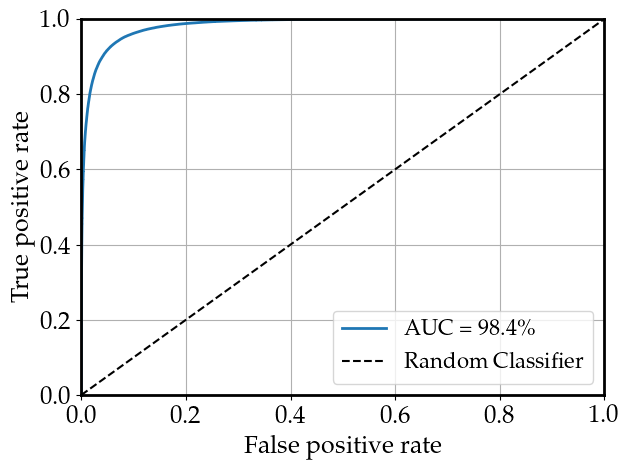

In [14]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_combined.pdf')
plt.show()

In [15]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_combined.pdf')

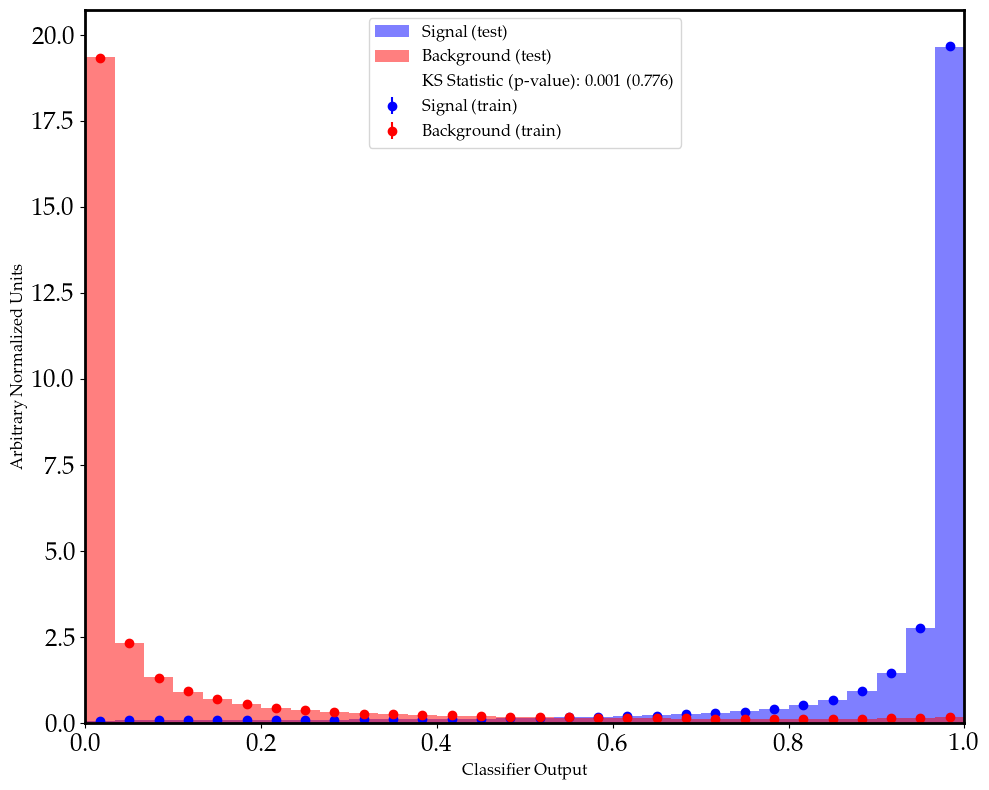

In [16]:
fig

In [17]:
# create a boosted decision tree classifier using the xgboost package
bdt = XGBClassifier(booster='gbtree')

In [19]:
%%time
# fit the BDT on training set
bdt.fit(X_train_final, y_train)

CPU times: user 1h 41min 41s, sys: 1min 8s, total: 1h 42min 50s
Wall time: 10min 59s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [20]:
# print the accuracies of the BDT on the training and testing data sets
print(bdt.score(X_train_final, y_train))
print(bdt.score(X_test_final, y_test))

0.9420776560606154
0.9397616866907315


In [21]:
# run BDT inference on train and test data sets and create ROC curve
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,0])

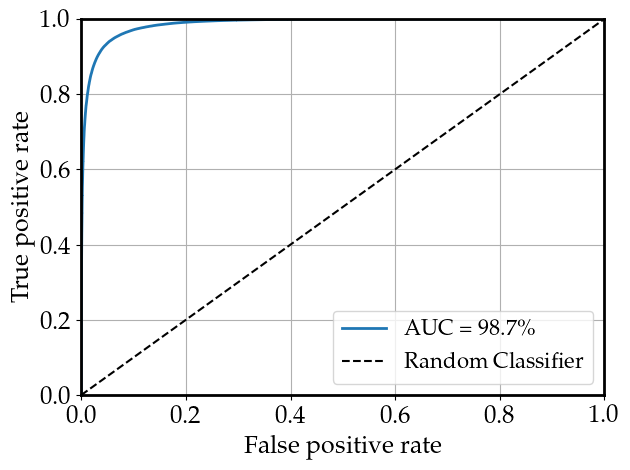

In [22]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_combined.pdf')
plt.show()

In [23]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,0],
                   y_test[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_combined.pdf')

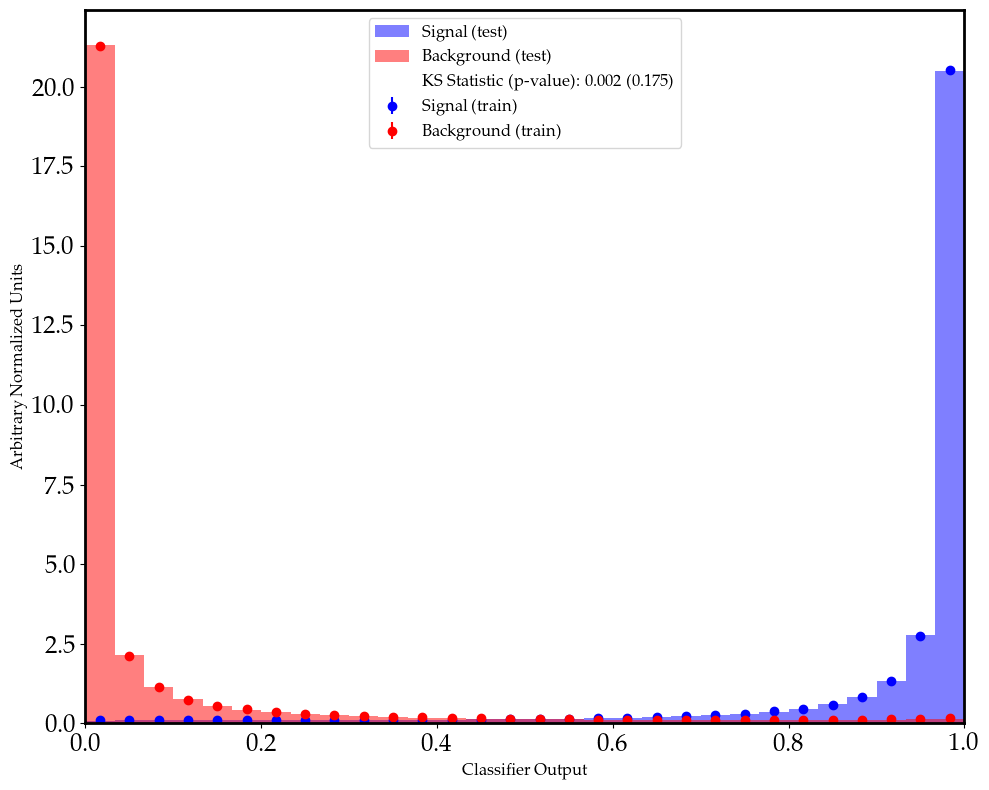

In [24]:
fig

In [25]:
# create Linear Discriminant Analysis classifier
fisher = LinearDiscriminantAnalysis()

In [26]:
%%time
# fit the LDA classifier on training set
fisher.fit(X_train_final, y_train[:,0])

CPU times: user 29.8 s, sys: 5.27 s, total: 35.1 s
Wall time: 16.5 s


LinearDiscriminantAnalysis()

In [27]:
# print the accuracies of the LDA classifier on the training and testing data sets
print(fisher.score(X_train_final, y_train[:,0]))
print(fisher.score(X_test_final, y_test[:,0]))

0.858677624763519
0.8591850295422301


In [28]:
# run LDA classifier inference on train and test data sets and create ROC curve
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test[:,0], predict_array_test[:,1])

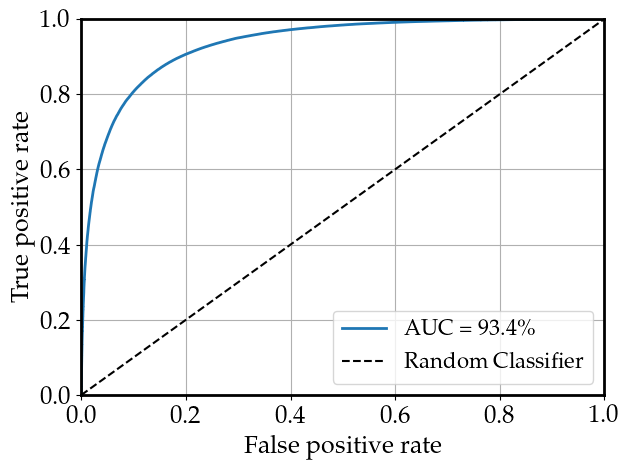

In [29]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_combined.pdf')
plt.show()

In [30]:
# create KS histogram of classifier output to check for overtraining
fig = make_ks_plot(y_train[:,0], predict_array_train[:,1],
                   y_test[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_combined.pdf')

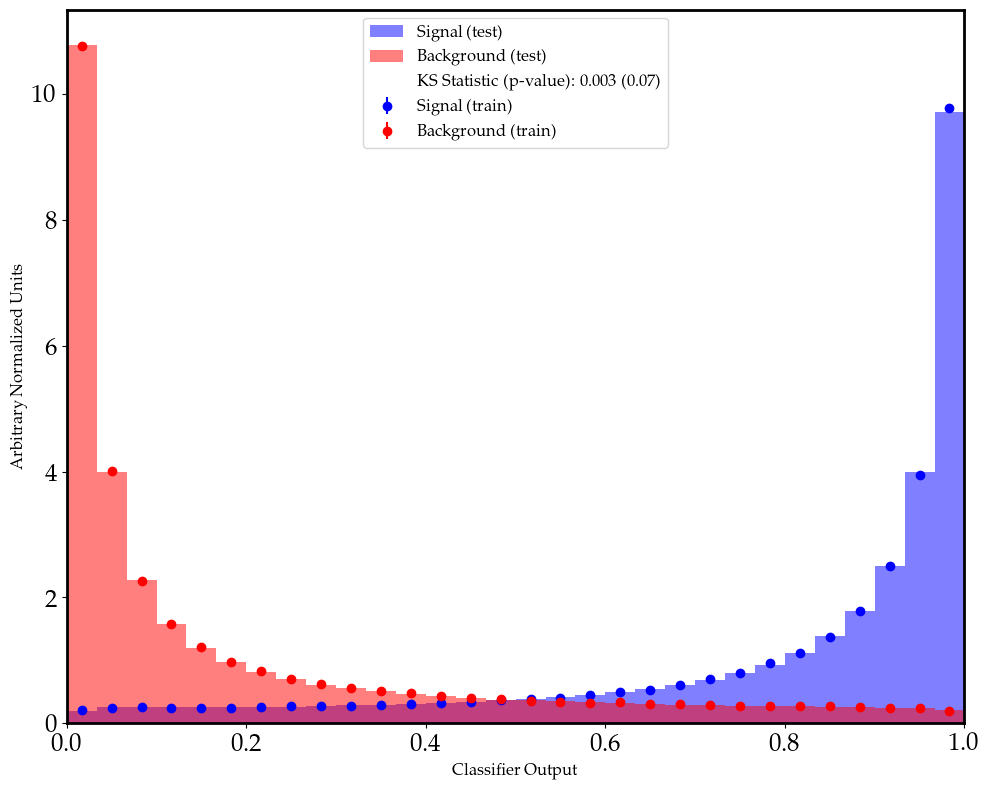

In [31]:
fig